In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import CuDNNLSTM 
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Flatten
from sklearn.metrics import mean_squared_error
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.models import load_model
import math  
# import concurrent.futures

In [2]:
#add the feature into the input data
def addFeature(feature, M):
    feature['year'] = pd.DatetimeIndex(feature['grantdate']).year
    feature['month'] = pd.DatetimeIndex(feature['grantdate']).month
    F = feature.groupby(['year','month']).size().reset_index()
    ## rename the name for citation column
    F = F.rename(columns = {0:"Citation"})
    M = pd.merge(M, F[['year','month','Citation']],
                on=['year','month'], how='left')
    M =M.fillna(0)
    
    return M

In [43]:
#generate the monthly input data
def monthly_data (subclass_data, feature):
    Mdf = subclass_data.groupby(['year','month'])
    C = Mdf.size().to_frame(name = 'count').reset_index()
    I = Mdf.sum().reset_index()
    pt = pd.date_range(start='1/1/1987', end = '12/31/2018', freq='M')
    pt_Y = pd.DatetimeIndex(pt).year
    pt_M = pd.DatetimeIndex(pt).month
    # create monthly data file
    M = pd.DataFrame(data = {'year':pt_Y, 'date':pt,'month':pt_M})
    M = pd.merge(M, C[['year','month','count']],
                    on=['year','month'], how='left')
    M = pd.merge(M, I[['year','month','Inventor']],
                    on=['year','month'], how='left')
    M = pd.merge(M, feature[['year','month','Citation']],
                    on=['year','month'], how='left')
    M =M.fillna(0)
    M = M.drop(columns=['year','month'])
    return M

In [27]:
#this function is used to generate an input data for a specific subclass
#the parameter is the subclass CPC, and the complete data file raw_data
#return the monthly and quarterly dataframe for subclass

def Raw2Input (CPC, raw_data, feature):
    # df is subclass data
    CPC = CPC.replace(' (20130101)',' \(20130101\)')
    df = raw_data[raw_data["CPC"].str.contains(CPC, na=False)]
    CPC = CPC.replace(' \(20130101\)','')
    citation = feature[feature["CPC"].str.contains(CPC, na=False)]
    #create data variable
    df['year'] = pd.DatetimeIndex(df['Appli-date']).year
    df['month'] = pd.DatetimeIndex(df['Appli-date']).month
    M = monthly_data(df, citation)
    Q = M.resample('Q', on = 'date').sum()
    Q = Q.reset_index()
    return (M,Q)

In [26]:
##import the patent data into the file
data = pd.read_csv('uspto.patent.appl-date.grant-date.txt',
                   names = ["ID","Grant-date","Appli-date","CPC"],sep='\t', 
                   dtype = {"CPC":str},header = None,nrows=7155645)
#remove the duplicated rows and now data with distinct patent ID
data.drop_duplicates(['ID'], keep = 'first', inplace = True)

##import inventor data into the file
Inventor = pd.read_csv('patent_Inventor.txt',names = ["ID","Name"],sep='\t', header = 0)
Inventors = Inventor.groupby(['ID']).count().reset_index()

##import citation information into the file
Citation = pd.read_csv('Citation.grouped.by.CPC.by.month.txt',sep='\t', header = 0)
Citation = Citation.rename(columns = {"number_of_citations_received":"Citation"})
Citation['year'] = pd.DatetimeIndex(Citation['year_month_']).year
Citation['month'] = pd.DatetimeIndex(Citation['year_month_']).month

#merge the inventor feature into the patent data
result = pd.merge(data, Inventors[['ID','Name']],
                 on='ID', how='left')
result = result.rename(columns={"Name":"Inventor"})


c:\users\delia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\users\delia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


        date  count  Inventor  Citation
0 1987-01-31    1.0       1.0       0.0
1 1987-02-28    0.0       0.0       1.0
2 1987-03-31    0.0       0.0       0.0
3 1987-04-30    1.0       1.0       0.0
4 1987-05-31    0.0       0.0       0.0

        date  count  Inventor  Citation
0 1987-03-31    1.0       1.0       1.0
1 1987-06-30    1.0       1.0       0.0
2 1987-09-30    0.0       0.0       0.0
3 1987-12-31    0.0       0.0       0.0
4 1988-03-31    0.0       0.0       0.0


In [6]:
Cal = data[data["ID"]=="10000772"]
Mit = data[data["ID"]=="8697359"]
CL=list(set(Cal.iloc[0]['CPC'].split('+')+Mit.iloc[0]['CPC'].split('+')))
# get the count of each CPC
cnt = np.zeros(len(CL))
for i in range(data.shape[0]):
    cpc = data.iloc[i]['CPC']
    if type(cpc) == float:
        continue
    for j in range(36):
        if CL[j] in cpc:
            cnt[j]+=1
PCL = pd.DataFrame(data = {'CPC':CL,'counts':cnt})
PL = PCL['CPC'][PCL['counts']>1000].values
PL

array(['C12N 15/70 (20130101)', 'C12Q 1/68 (20130101)',
       'C12N 15/111 (20130101)', 'C12N 2310/11 (20130101)',
       'A61K 48/00 (20130101)', 'C12N 2310/14 (20130101)',
       'C12N 15/113 (20130101)', 'C12N 9/22 (20130101)',
       'C12N 15/63 (20130101)', 'C12N 15/85 (20130101)'], dtype=object)

In [44]:
# generate the input data for subclass data
(M,Q) = Raw2Input(PL[0], result, Citation)
print(Q.head())

        date  count  Inventor  Citation
0 1987-01-31    0.0       0.0       2.0
1 1987-01-31    0.0       0.0       1.0
2 1987-02-28    3.0       9.0       1.0
3 1987-03-31    7.0      27.0       1.0
4 1987-03-31    7.0      27.0       1.0

        date  count  Inventor  Citation
0 1987-03-31   38.0     144.0      11.0
1 1987-06-30   27.0      60.0      16.0
2 1987-09-30    5.0       7.0       5.0
3 1987-12-31   24.0      78.0      13.0
4 1988-03-31   10.0      42.0       6.0


c:\users\delia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\delia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


c:\users\delia\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


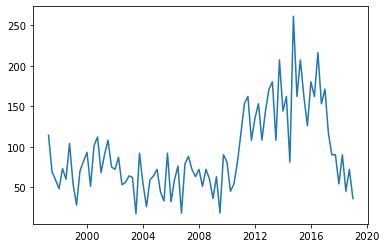

In [46]:
plt.plot(Q['date'][40:128],Q['count'][40:128])

In [7]:
#using LSTM to model the data and get the prediction
from LSTM import *
n_neuron = 0
time_step = 0
LSTM_PA = run_lstm(Q, n_neuron, time_step)
SSE = ((test[:,-1]-PA_inverse)**2).sum()
SSR = ((test[:,-1]-np.mean(train[:,-1]))**2).sum()
OSR2 = 1-SSE/SSR
RMSE = math.sqrt(np.mean((test[:,-1]-PA_inverse)**2))
MAE = np.mean(abs((test[:,-1]-PA_inverse)))
print("OSR2: ", OSR2)
print("MAE: ", MAE)
print("MAE_monthly", MAE/3)
print("RMSE: ", RMSE)
print("RMSE_monthly", RMSE/3)

In [ ]:
#using arima to model the data and plot the result
from ARIMA import *
automodel = arimamodel(Q['count'])
automodel.summary()
plotarima(10, Q['count'], automodel)
y_pred = automodel.predict(n_periods=10, return_conf_int=False)
SSE = ((test[:,-1] - y_pred)**2).sum()
SSR = ((test[:,-1] - np.mean(ts.values))**2).sum()
OSR2 = 1-SSE/SSR
RMSE = math.sqrt(np.mean((test[:,-1] - y_pred)**2))
MAE = np.mean(abs((test[:,-1] - y_pred)))
print("OSR2: ", OSR2)
print("MAE: ", MAE)
print("RMSE: ", RMSE)

In [ ]:
#using VAR to model the data and get the prediction
from VAR import *
var_pred = fitVar(Q)
SSE = ((test[:,-1] - var_pred)**2).sum()
SSR = ((test[:,-1] - np.mean(ts.values))**2).sum()
OSR2 = 1-SSE/SSR
RMSE = math.sqrt(np.mean((test[:,-1] - var_pred)**2))
MAE = np.mean(abs((test[:,-1] - var_pred)))
print("OSR2: ", OSR2)
print("MAE: ", MAE)
print("RMSE: ", RMSE)